In [1]:
import pyssam

In [2]:
from copy import copy
import matplotlib.pyplot as plt
import numpy as np

First, we source landmark data to use in our shape model

In [3]:
LANDMARK_DIR = "../exampleData/gamesData/"
landmark_files = glob(LANDMARK_DIR + "/landmarks*.csv")
if len(landmark_files) == 0:
  raise AssertionError(
    "The directories you have declared are empty.",
    "\nPlease check your input arguments.",
  )

landmark_coordinates = np.array(
  [np.loadtxt(l, delimiter=",") for l in landmark_files]
)

# Initialising the model

Here we convert to landmark coordinates into a parameterised shape model. We first initialise the class, which handles all pre-processing. Then, we can compute the shape model components and mean population shape

In [4]:
ssm_obj = pyssam.SSM(landmark_coordinates)
ssm_obj.create_pca_model(ssm_obj.landmarks_columns_scale)
mean_shape_columnvector = ssm_obj.compute_dataset_mean()
mean_shape = mean_shape_columnvector.reshape(-1, 3)
shape_model_components = ssm_obj.pca_model_components

Reduced to 24 components from 48 for 90.0% variation


# Plotting and analysis

In [5]:
# Define some plotting functions

def plot_cumulative_variance(explained_variance, target_variance=-1):
    number_of_components = np.arange(0, len(explained_variance))+1
    fig, ax = plt.subplots(1,1)
    color = "blue"
    ax.plot(number_of_components, explained_variance*100.0, marker="o", ms=2, color=color, mec=color, mfc=color)
    if target_variance > 0.0:
        ax.axhline(target_variance*100.0)
    
    ax.set_ylabel("Variance [%]")
    ax.set_xlabel("Number of components")
    ax.grid(axis="x")
    plt.show()
    
def plot_shape_modes(
  mean_shape_columnvector, 
  mean_shape, 
  original_shape_parameter_vector,
  shape_model_components,
):
  weights = [-2, 0, 2]
  fig, ax = plt.subplots(1, 3)
  for j, weights_i in enumerate(weights):
    shape_parameter_vector = copy(original_shape_parameter_vector)
    shape_parameter_vector[mode_to_plot] = weights_i
    mode_i_coords = ssm_obj.morph_model(
        mean_shape_columnvector, 
        shape_model_components, 
        shape_parameter_vector
    ).reshape(-1, 3)

    offset_dist = pyssam.utils.euclidean_distance(
      mean_shape, 
      mode_i_coords
    )
    # colour points blue if closer to point cloud centre than mean shape
    mean_shape_dist_from_centre = pyssam.utils.euclidean_distance(
      mean_shape,
      np.zeros(3),
    )
    mode_i_dist_from_centre = pyssam.utils.euclidean_distance(
      mode_i_coords,
      np.zeros(3),
    )
    offset_dist = np.where(
        mode_i_dist_from_centre<mean_shape_dist_from_centre,
        offset_dist*-1,
        offset_dist,
    )
    if weights_i == 0:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 2],
        c="gray",
        s=1,
      )
      ax[j].set_title("mean shape")
    else:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 2],
        c=offset_dist,
        cmap="seismic",
        vmin=-1,
        vmax=1,
        s=1,
      )
      ax[j].set_title(f"mode {mode_to_plot} \nweight {weights_i}")
    ax[j].axis('off')
    ax[j].margins(0,0)
    ax[j].xaxis.set_major_locator(plt.NullLocator())
    ax[j].yaxis.set_major_locator(plt.NullLocator())

  plt.show()

Generally, the first part in assessing the model once trained is visualising how the explained variance changes with an increasing number of modes. If few modes are required, it means it will be much simpler to fit the SSM to an image.

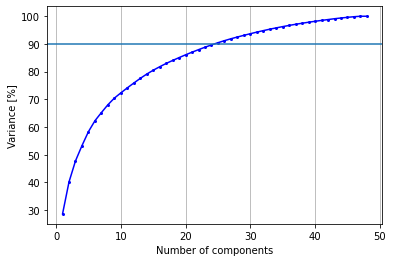

In [6]:
plot_cumulative_variance(np.cumsum(ssm_obj.pca_object.explained_variance_ratio_), 0.9)

Now the interesting part. We visualise the first three principal components, where the points are coloured by their displacement. 

explained variance is 0.28627210473720655


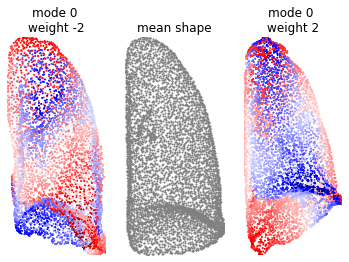

In [8]:
mode_to_plot = 0
print(f"explained variance is {ssm_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

plot_shape_modes(
    mean_shape_columnvector, 
    mean_shape, 
    ssm_obj.model_parameters,
    ssm_obj.pca_model_components,
)

explained variance is 0.11562461259525633


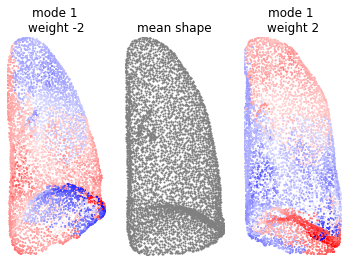

In [9]:
mode_to_plot = 1
print(f"explained variance is {ssm_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

plot_shape_modes(
    mean_shape_columnvector, 
    mean_shape, 
    ssm_obj.model_parameters,
    ssm_obj.pca_model_components,
)

explained variance is 0.07577465318882819


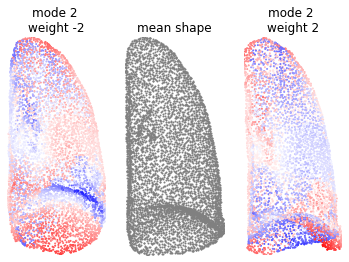

In [10]:
mode_to_plot = 2
print(f"explained variance is {ssm_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

plot_shape_modes(
    mean_shape_columnvector, 
    mean_shape, 
    ssm_obj.model_parameters,
    ssm_obj.pca_model_components,
)

When we look at the 15th mode, which accounts for around 1% for the total variance, we can see a very minor change in the lung structure

explained variance is 0.01252539925342082


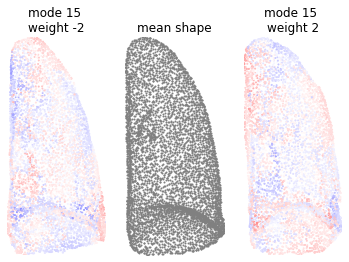

In [11]:
mode_to_plot = 15
print(f"explained variance is {ssm_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

plot_shape_modes(
    mean_shape_columnvector, 
    mean_shape, 
    ssm_obj.model_parameters,
    ssm_obj.pca_model_components,
)